In [155]:
import numpy as np
import os
import librosa
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Activation,Reshape,MaxPooling2D, Dropout, Conv2D, MaxPool2D, Flatten

## Dataset

- We will use the dataset containing real and fake audio of well known people from 
https://www.kaggle.com/datasets/birdy654/deep-voice-deepfake-voice-recognition

- The dataset is available under MIT License.

- Download the Audio folder from above URL and save it with folder name "AudioClassification". It contains two sub folders  - FAKE and REAL containing fake and real audio files respectively. Also download two files under the folder 'DEMONSTRATION' to test our audio classifier. These files are named as 'linus-original-DEMO.mp3' and 'linus-to-musk-DEMO.mp3', they contain original voice of Linus and voice of Linus converted to that of Elon Musk. 


- The code given here is inspired by the solutions to DEEP-VOICE: DeepFake Voice Recognition at Kaggle.com (https://www.kaggle.com/datasets/birdy654/deep-voice-deepfake-voice-recognition)

- The below code was implemented in Jupyter Notebook under Anaconda 3 Python Distribution (Python 3.11.9) on a Windows 11 PC. 



In [239]:
# this code loads Real and Fake audio files dataset

paths = [] #list of audio file paths (both real and fake)

# Label of each audio file is the name of folder it is in (REAL or FAKE)
labels = []# list of labels corresponding to each audio

# Define the path of folder containing audio files
audio_dir = 'AudioClassification\Audio'

#Subfolder containing real audio samples
real_audio_path = 'REAL'

#Subfolder containing fake audio samples
fake_audio_path = 'FAKE'

#for all subfolders in audio_dir we store the file name of each file in it and the corresponding label
for dir in os.listdir(audio_dir):
    dir_path = os.path.join(audio_dir, dir)
    if os.path.isdir(dir_path):
         for filename in os.listdir(dir_path):
            file_path = os.path.join(dir_path, filename)
            paths.append(file_path)
            labels.append(dir)

            
#let us see the subfolders in audio_dir
folders = os.listdir(audio_path)
print("The audio directory has following folders:", folders)

paths_and_labels = pd.DataFrame({'path': paths, 'label': labels} )
paths_and_labels.head(64)
            


The audio directory has following folders: ['FAKE', 'REAL']


path label
0   AudioClassification\Audio\FAKE\biden-to-linus.wav  FAKE
1   AudioClassification\Audio\FAKE\biden-to-margot...  FAKE
2    AudioClassification\Audio\FAKE\biden-to-musk.wav  FAKE
3   AudioClassification\Audio\FAKE\biden-to-Obama.wav  FAKE
4    AudioClassification\Audio\FAKE\biden-to-ryan.wav  FAKE
..                                                ...   ...
59   AudioClassification\Audio\REAL\musk-original.wav  REAL
60  AudioClassification\Audio\REAL\obama-original.wav  REAL
61   AudioClassification\Audio\REAL\ryan-original.wav  REAL
62  AudioClassification\Audio\REAL\taylor-original...  REAL
63  AudioClassification\Audio\REAL\trump-original.wav  REAL

[64 rows x 2 columns]

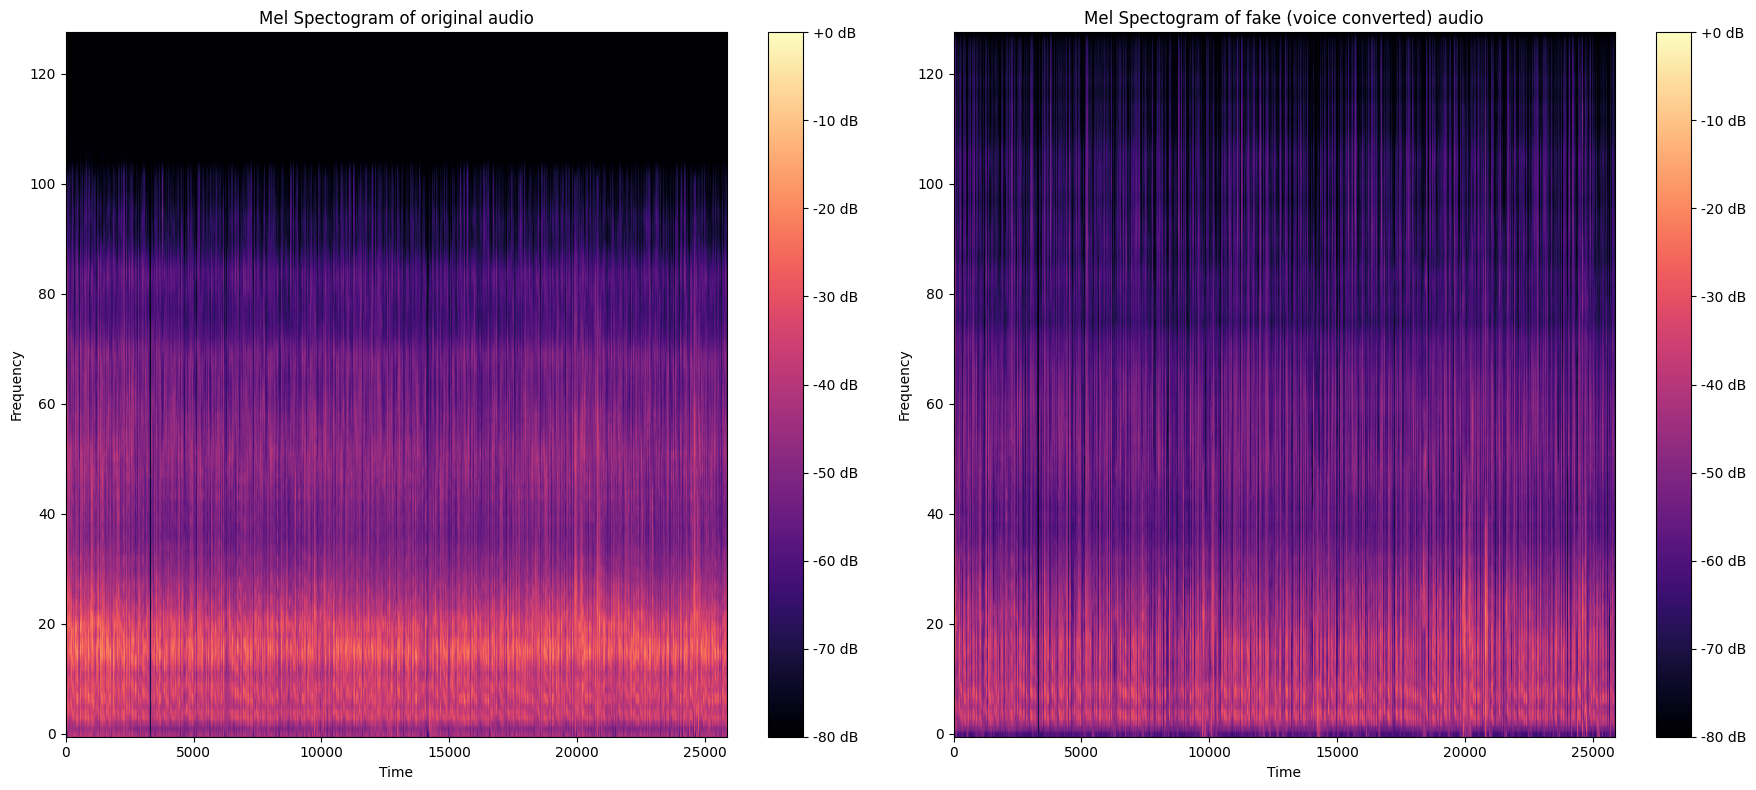

In [248]:
# Let us plot the mel-spectrogram a real audio musk-original.wav and that of the mel-spectrogram corresponding fake (voice converted) audio musk-original.wav using librosa library
real_audio = "AudioClassification\Audio\REAL\musk-original.wav"
fake_audio = "AudioClassification\Audio\FAKE\musk-to-obama.wav"

real_ad, real_sr = librosa.load(real_audio)
fake_ad, fake_sr = librosa.load(fake_audio)

real_mel_spect = librosa.feature.melspectrogram(y=real_ad, sr=real_sr)
real_mel_spect = librosa.power_to_db(real_mel_spect, ref=np.max)

fake_mel_spect = librosa.feature.melspectrogram(y=fake_ad, sr=fake_sr)
fake_mel_spect = librosa.power_to_db(fake_mel_spect, ref=np.max)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))




im1 = ax1.imshow(real_mel_spect, origin='lower', aspect='auto', cmap='magma')
#librosa.display.specshow(real_mel_spect, y_axis="mel", x_axis="time", ax=ax1)
ax1.set_title("Mel Spectogram of original audio")
plt.colorbar(im1, ax = ax1,format="%+2.0f dB")
ax1.set_xlabel("Time")
ax1.set_ylabel("Frequency")


im2 = ax2.imshow(fake_mel_spect, origin='lower', aspect='auto', cmap='magma')
#librosa.display.specshow(fake_mel_spect, y_axis="mel", x_axis="time", ax = ax2)
ax2.set_title("Mel Spectogram of fake (voice converted) audio")
plt.colorbar(im2,ax= ax2, format="%+2.0f dB")
ax2.set_xlabel("Time")
ax2.set_ylabel("Frequency")


plt.tight_layout()

plt.show()



In [164]:
# This function extracts Mel-Frequency Cepstral Coefficients as features from each audio sample 
# The Python library librosa is used to extract the features

def extract_mfcc_features(audio_path, max_length=1000):
    features = []
    labels = []
    for folder in os.listdir(audio_path):
        folder_path = os.path.join(audio_path, folder)
        for file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file)
            try:
                # Load audio file
                audio, _ = librosa.load(file_path, sr=16000)
                # Extract features (example: using Mel-Frequency Cepstral Coefficients)
                mfccs = librosa.feature.mfcc(y=audio, sr=16000, n_mfcc=100)
                # Pad or trim the feature array to a fixed length
                if mfccs.shape[1] < max_length:
                    mfccs = np.pad(mfccs, ((0, 0), (0, max_length - mfccs.shape[1])), mode='constant')
                else:
                    mfccs = mfccs[:, :max_length]
                features.append(mfccs)
                # Assign label
                if folder == 'FAKE':
                    labels.append(1)  # 1 for fake
                else:
                    labels.append(0)  # 0 for real
            except Exception as e:
                print(f"Error encountered while parsing file: {file_path}")
                continue
    return np.array(features), np.array(labels)


In [165]:
# We call extract_features() function to extract features from our audio files
audio_path = 'AudioClassification/Audio'
X, y = extract_mfcc_features(audio_path)


Features shape: (64, 40, 500)
Labels shape: (64,)


In [166]:
print("Features shape:", X.shape)
print("Labels shape:", y.shape)

Features shape: (64, 100, 1000)
Labels shape: (64,)


In [167]:
# Let us split the features set and labels into train and test portions
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [200]:
model = Sequential()

model.add(Input(shape = (X_train.shape[1:])))
model.add(Reshape((100,1000,1)))

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
   


model.add(GlobalAveragePooling2D())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))  

In [213]:
model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics  = ['accuracy'])
history = model.fit(X_train, y_train, epochs = 500, batch_size = 32, validation_data = [X_test,y_test])

Epoch 1/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 503ms/step - accuracy: 0.9034 - loss: 0.3085 - val_accuracy: 0.7692 - val_loss: 0.6877
Epoch 2/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 379ms/step - accuracy: 0.9034 - loss: 0.3122 - val_accuracy: 0.7692 - val_loss: 0.6825
Epoch 3/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 376ms/step - accuracy: 0.8930 - loss: 0.3244 - val_accuracy: 0.7692 - val_loss: 0.6153
Epoch 4/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 362ms/step - accuracy: 0.8930 - loss: 0.3157 - val_accuracy: 0.7692 - val_loss: 0.6430
Epoch 5/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 359ms/step - accuracy: 0.8930 - loss: 0.2762 - val_accuracy: 0.7692 - val_loss: 0.7461
Epoch 6/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 361ms/step - accuracy: 0.8930 - loss: 0.3406 - val_accuracy: 0.7692 - val_loss: 0.7646
Epoch 7/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 376ms/step - accuracy: 0.9138 - loss: 0.2723 - val_accuracy: 0.7692 - val_loss: 0.7369
Epoch 8/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 425ms/step - accuracy: 0.9034 - loss: 0.3199 - val_accuracy: 0.7692 - v

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 391ms/step - accuracy: 0.9165 - loss: 0.2106 - val_accuracy: 0.7692 - val_loss: 0.5064
Epoch 102/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 391ms/step - accuracy: 0.9060 - loss: 0.2096 - val_accuracy: 0.7692 - val_loss: 0.5321
Epoch 103/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 406ms/step - accuracy: 0.9165 - loss: 0.2273 - val_accuracy: 0.7692 - val_loss: 0.4973
Epoch 104/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 391ms/step - accuracy: 0.9400 - loss: 0.2264 - val_accuracy: 0.7692 - val_loss: 0.4599
Epoch 105/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 435ms/step - accuracy: 0.9269 - loss: 0.1883 - val_accuracy: 0.7692 - val_loss: 0.4861
Epoch 106/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 392ms/step - accuracy: 0.9400 - loss: 0.1937 - val_accuracy: 0.7692 - val_loss: 0.4857
Epoch 107/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 391ms/step - accuracy: 0.9165 - loss: 0.1705 - val_accuracy: 0.7692 - val_loss: 0.5170
Epoch 108/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 443ms/step - accuracy: 0.9269 - loss: 0.1925 - val_accuracy: 0.7692 -

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 433ms/step - accuracy: 0.9400 - loss: 0.0784 - val_accuracy: 0.7692 - val_loss: 0.6311
Epoch 202/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 375ms/step - accuracy: 0.9295 - loss: 0.1682 - val_accuracy: 0.7692 - val_loss: 0.5296
Epoch 203/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 407ms/step - accuracy: 0.9634 - loss: 0.0840 - val_accuracy: 0.7692 - val_loss: 0.2817
Epoch 204/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 411ms/step - accuracy: 1.0000 - loss: 0.0713 - val_accuracy: 1.0000 - val_loss: 0.2481
Epoch 205/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 433ms/step - accuracy: 0.9530 - loss: 0.1127 - val_accuracy: 0.8462 - val_loss: 0.2496
Epoch 206/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 391ms/step - accuracy: 0.9765 - loss: 0.0691 - val_accuracy: 0.7692 - val_loss: 0.5273
Epoch 207/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 380ms/step - accuracy: 0.9634 - loss: 0.0928 - val_accuracy: 0.7692 - val_loss: 0.6615
Epoch 208/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 422ms/step - accuracy: 0.9400 - loss: 0.1776 - val_accuracy: 0.7692 -

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 471ms/step - accuracy: 1.0000 - loss: 0.0560 - val_accuracy: 0.7692 - val_loss: 0.3122
Epoch 302/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 451ms/step - accuracy: 0.9765 - loss: 0.0585 - val_accuracy: 0.7692 - val_loss: 0.4277
Epoch 303/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 484ms/step - accuracy: 1.0000 - loss: 0.0281 - val_accuracy: 0.7692 - val_loss: 0.5875
Epoch 304/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 436ms/step - accuracy: 0.9530 - loss: 0.1071 - val_accuracy: 0.7692 - val_loss: 0.3645
Epoch 305/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 444ms/step - accuracy: 1.0000 - loss: 0.0321 - val_accuracy: 0.9231 - val_loss: 0.2162
Epoch 306/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 429ms/step - accuracy: 0.9765 - loss: 0.0462 - val_accuracy: 0.9231 - val_loss: 0.2046
Epoch 307/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 447ms/step - accuracy: 0.9530 - loss: 0.0924 - val_accuracy: 0.7692 - val_loss: 0.3130
Epoch 308/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 438ms/step - accuracy: 1.0000 - loss: 0.0304 - val_accuracy: 0.7692 -

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 397ms/step - accuracy: 1.0000 - loss: 0.0170 - val_accuracy: 0.7692 - val_loss: 0.2536
Epoch 402/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 395ms/step - accuracy: 0.9869 - loss: 0.0251 - val_accuracy: 0.7692 - val_loss: 0.2789
Epoch 403/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 378ms/step - accuracy: 1.0000 - loss: 0.0169 - val_accuracy: 0.9231 - val_loss: 0.1842
Epoch 404/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 380ms/step - accuracy: 1.0000 - loss: 0.0306 - val_accuracy: 0.9231 - val_loss: 0.1700
Epoch 405/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 381ms/step - accuracy: 1.0000 - loss: 0.0179 - val_accuracy: 0.8462 - val_loss: 0.2451
Epoch 406/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 380ms/step - accuracy: 1.0000 - loss: 0.0267 - val_accuracy: 0.7692 - val_loss: 0.3880
Epoch 407/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 393ms/step - accuracy: 0.9869 - loss: 0.0221 - val_accuracy: 0.7692 - val_loss: 0.3244
Epoch 408/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 379ms/step - accuracy: 1.0000 - loss: 0.0173 - val_accuracy: 0.9231 -

In [215]:
model.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape_15 (Reshape)                 │ (None, 100, 1000, 1)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_50 (Conv2D)                   │ (None, 98, 998, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_49 (MaxPooling2D)      │ (None, 49, 499, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_51 (Conv2D)                   │ (None, 47, 497, 64)         │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_50 (MaxPooling2D)      │ (None, 23, 248, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_6           │ (None, 64)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 81,797 (319.52 KB)

 Trainable params: 27,265 (106.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 54,532 (213.02 KB)

In [216]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8462 - loss: 0.2146
Test Loss: 0.21456041932106018
Test Accuracy: 0.8461538553237915


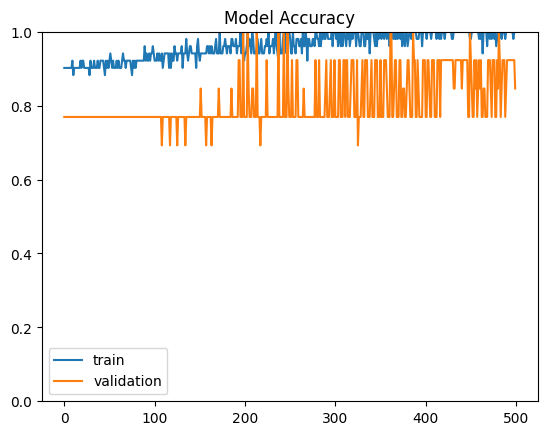

In [217]:
plt.figure()
plt.title("Model Accuracy")
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="validation")
plt.legend()
plt.ylim([0, 1])
plt.show()

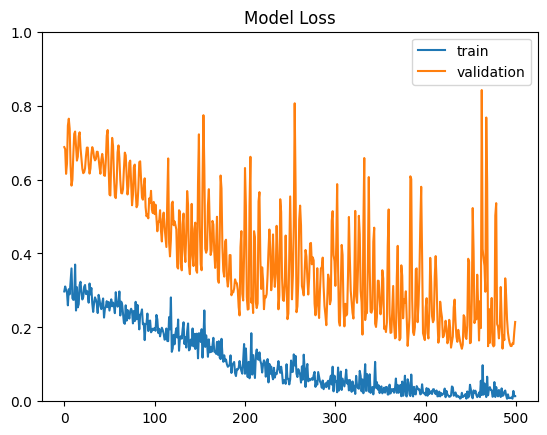

In [218]:
plt.figure()
plt.title("Model Loss")
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="validation")
plt.legend()
plt.ylim([0, 1])
plt.show()

In [219]:
loss,accuracy = model.evaluate(X_test,y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.8462 - loss: 0.2146


In [220]:
y_pred = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


In [221]:
def convert_to_labels(predictions, threshold=0.5):
    labels = []
    for prob in predictions:
        if prob >= threshold:
            labels.append("Real")
        else:
            labels.append("Fake")
    return labels
labels = convert_to_labels(y_pred)
print(labels)

['Real', 'Fake', 'Real', 'Real', 'Real', 'Real', 'Real', 'Real', 'Real', 'Fake', 'Real', 'Fake', 'Real']


In [222]:
labels = convert_to_labels(y_test)
print(labels)

['Real', 'Fake', 'Real', 'Real', 'Real', 'Real', 'Real', 'Real', 'Real', 'Fake', 'Fake', 'Real', 'Real']


In [223]:
import os
def extract_features_single_audio(filename, max_length = 1000):
    features = []
    audio, _ = librosa.load(filename, sr = 16000)
    mfccs = librosa.feature.mfcc(y=audio, sr=16000, n_mfcc=100)
    # Pad or trim the feature array to a fixed length
    if mfccs.shape[1] < max_length:
        mfccs = np.pad(mfccs, ((0, 0), (0, max_length - mfccs.shape[1])), mode='constant')
    else:
        mfccs = mfccs[:, :max_length]
    features.append(mfccs)
    return np.array(features)           

In [224]:
def classify_an_audiosample(filename):
    audio_features = extract_features_single_audio(realfilename)
    print(audio_features.shape)
    result_array = model.predict(audio_features)
    print(convert_to_labels(result_array))    

In [225]:
fakeaudioname = "AudioClassification/linus-to-musk-DEMO.mp3"
classify_an_audiosample(fakeaudioname)

(1, 100, 1000)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
['Fake']


In [227]:
realaudioname = "AudioClassification/linus-original-DEMO.mp3"
classify_an_audiosample(realaudioname)

(1, 100, 1000)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
['Fake']
